In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-2023-dataset/House_Price_dataset.csv

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
df = pd.read_csv('/kaggle/input/house-prices-2023-dataset/House_Price_dataset.csv')
df.head()

In [ ]:
# temel bilgiler edinelim
print(df.info())
print(df.describe())
print(df.isnull().sum())
df.nunique()

In [ ]:
# temizlik yapalım, gereksiz olduğu düşünülen sütunları çıkaralım
necessary = df[['property_type', 'location', 'bedrooms', 'baths', 'city', 'purpose', 'Area Size', 'price']].drop_duplicates().copy()
necessary.dropna(inplace=True)
print(necessary.head())
necessary.isnull().sum()

In [ ]:
# preprocessing adımlarını uygulayalım

X = necessary.drop('price', axis=1)
y = necessary['price']

scaler = MinMaxScaler()
y = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

categorical_features = ['property_type', 'location', 'city', 'purpose']
numerical_features = ['bedrooms', 'baths', 'Area Size']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', MinMaxScaler(), numerical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [ ]:
# hiperparametremizi girelim
param_grid = {
    'regressor__fit_intercept': [True, False]
}

In [ ]:
# grid search uygulayalım (lineer regresyon)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# performansımızı değerlendirelim
mse = mean_squared_error(y_test, y_pred)
print(f"Ortalama Kare Hatası (MSE): {mse}")
print(f"En iyi hiperparametreler: {grid_search.best_params_}")

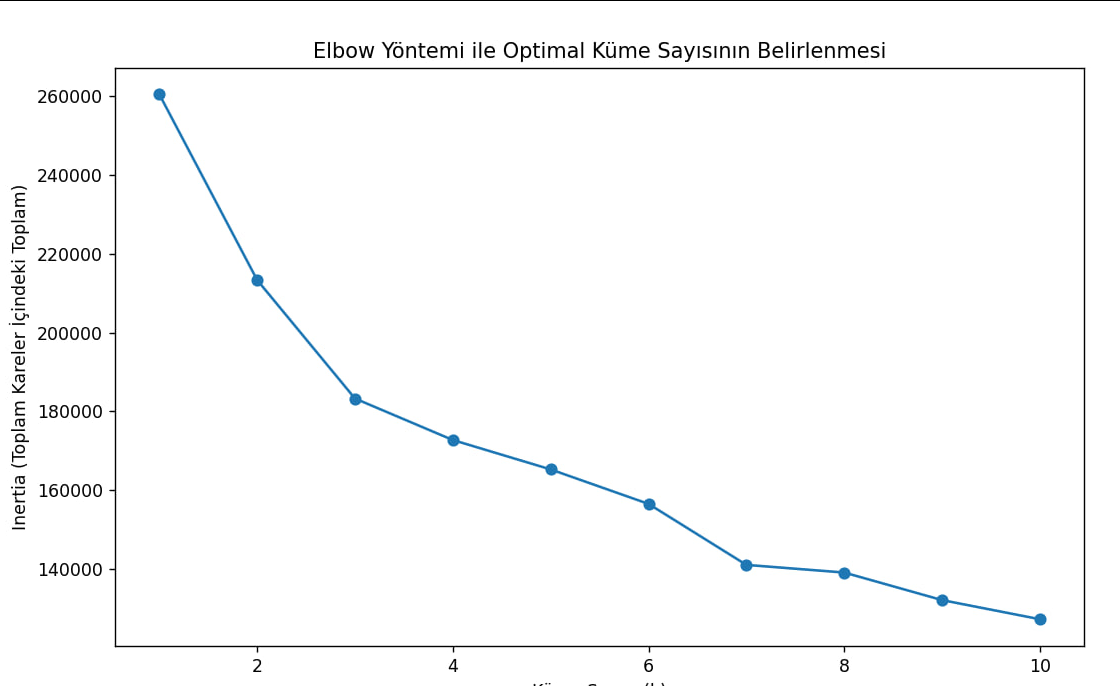
burada elbow metodu ile 1-10 arasındaki küme sayılarını belirledim ve optimum değerin 3 olduğuna karar verdim

In [ ]:
# kmeans uygulayalım
kmeans = KMeans(n_clusters=3, random_state=42)
X_preprocessed = best_model.named_steps['preprocessor'].transform(X)
kmeans.fit(X_preprocessed)
clusters = kmeans.predict(X_preprocessed)

# silhouette skorumuzu değerlendirelim
silhouette_avg = silhouette_score(X_preprocessed, clusters)
print(f"Silhouette Skoru: {silhouette_avg}")